In [3]:
import numpy as np
import pandas as pd
import scipy.stats
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
import plotly.express as px

import yfinance as yf
from arch import arch_model 
from copulae import (NormalCopula, GaussianCopula, StudentCopula, 
                     ClaytonCopula, FrankCopula, GumbelCopula)

plt.style.use("bmh")
%config InlineBackend.figure_formats=["png"]
import multiprocessing as mp
print(mp.cpu_count())

4


### Загрузка данных

In [4]:
# Apple, Microsoft, Amazon, Netflix, TSLA
tickers_list = ['AAPL', 'MSFT', 'AMZN', 'NFLX', 'TSLA']

# период времени
start_date, end_date = '2017-01-01','2022-01-01'

# prices - тут будут храниться котировки акций
prices = pd.DataFrame(columns=tickers_list)

for ticker in tickers_list:
    prices[ticker] = yf.download(ticker, start_date, end_date)['Close']

prices.head()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,AAPL,MSFT,AMZN,NFLX,TSLA
Date,,,,,
2017-01-03,29.037500,62.580002,37.683498,127.489998,14.466000
2017-01-04,29.004999,62.299999,37.859001,129.410004,15.132667
2017-01-05,29.152500,62.299999,39.022499,131.809998,15.116667
2017-01-06,29.477501,62.840000,39.799500,131.070007,15.267333
2017-01-09,29.747499,62.639999,39.846001,130.949997,15.418667


#### Графики цен

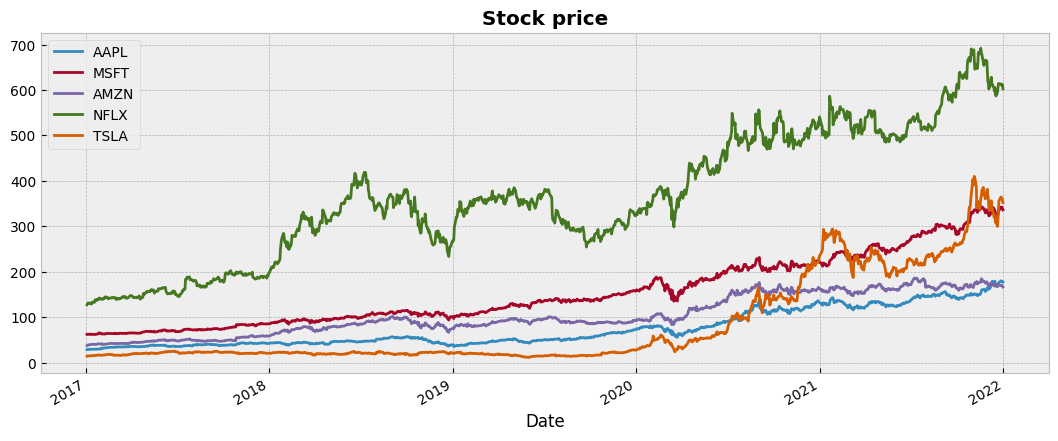

In [5]:
prices.plot(figsize=(13, 5))
plt.title("Stock price", weight="bold")
plt.show()

#### Графики доходностей

In [6]:
returns = 100 * prices.pct_change().dropna()
returns.head()

,AAPL,MSFT,AMZN,NFLX,TSLA
Date,,,,,
2017-01-04,-0.111928,-0.447431,0.465728,1.506005,4.608510
2017-01-05,0.508536,0.000000,3.073240,1.854566,-0.105730
2017-01-06,1.114830,0.866775,1.991160,-0.561407,0.996690
2017-01-09,0.915948,-0.318270,0.116839,-0.091562,0.991226
2017-01-10,0.100851,-0.031929,-0.127999,-0.809467,-0.609650


In [7]:
'''
5 временных рядов на одном графике сильно накладываются друг на друга. К тому же, хочется 
посмотреть некоторые особенности доходностей (сколько, когда и т.д.). Поэтому этот график построил с 
помощью plotly.express
'''

px.line(returns, title="Daily returns")

#### Графики совместных распределений

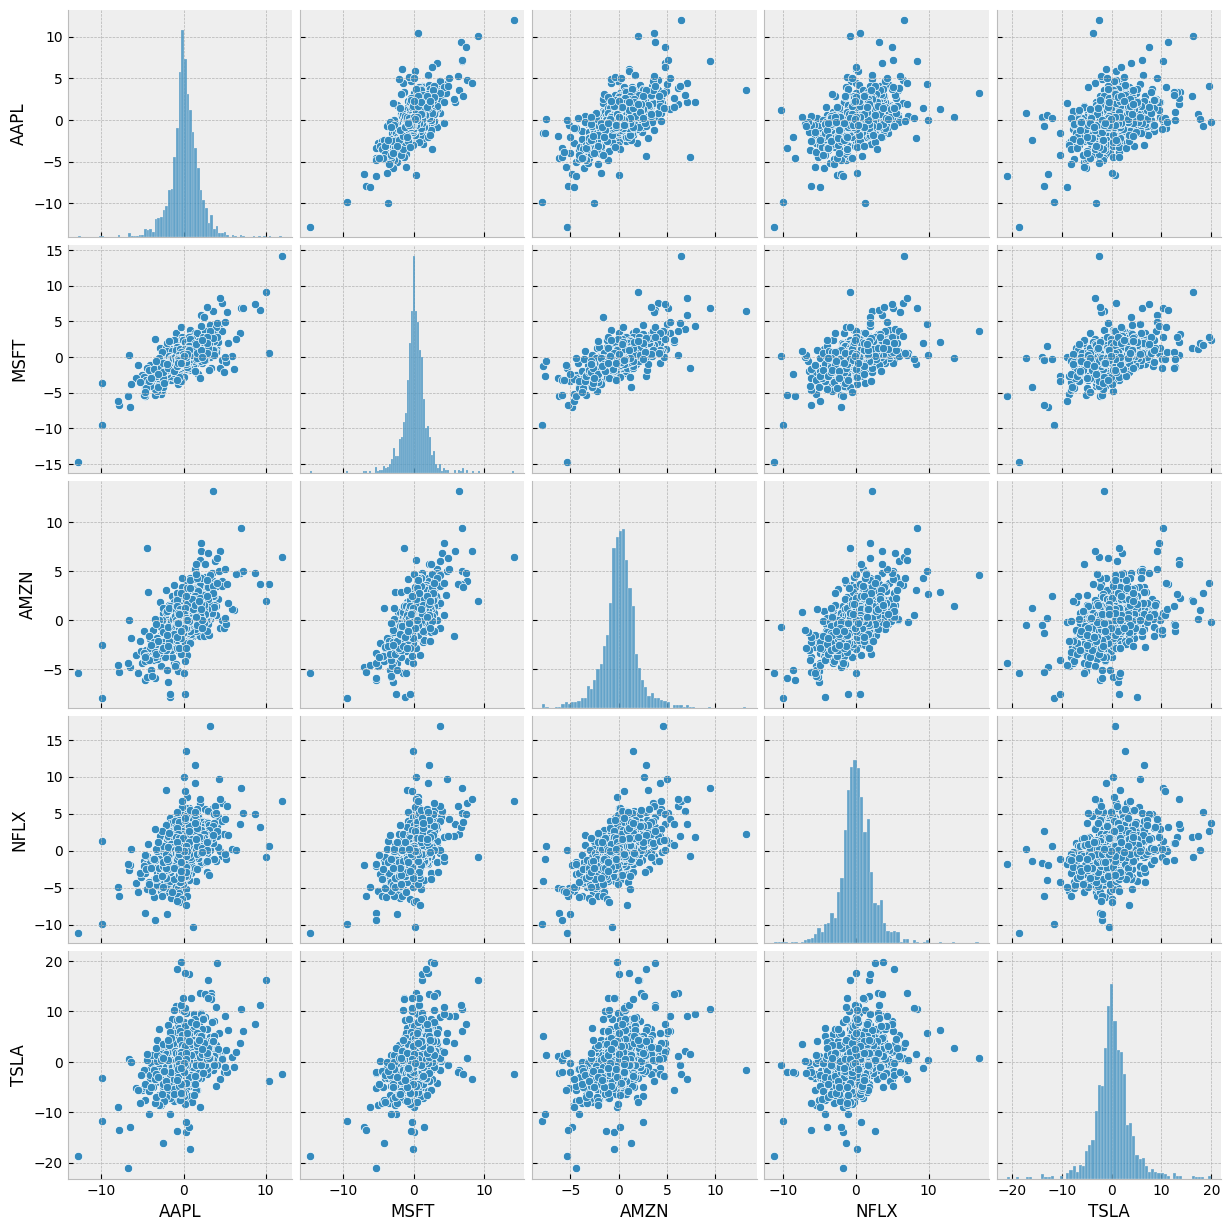

In [8]:
sns.pairplot(returns)
plt.show()

# заметна небольшая корреляция между доходностями Apple И Microsoft

In [9]:
# функция для проведения теста Купика
ALPHA = 0.05

def kupiec_test(VaR_curve, actual_returns, pp=0.05):
    T = len(actual_returns)
    K = (actual_returns < VaR_curve).sum()
    alpha_0 = K / T
    S = -2 * np.log((1 - ALPHA)**(T - K) * ALPHA**K) + 2 * np.log((1 - alpha_0)**(T - K) * alpha_0**K)
    p_value = 1 - scipy.stats.chi2.cdf(S, df=1)
        
    if np.isnan(p_value):
        p_value = 0.
        
    print('Количество наблюдений:', T)
    print('Желаемый уровень пробитий: {:.1f}%'.format(ALPHA * 100))
    print('Уровень пробитий в модели: {:.2f}%'.format(alpha_0 * 100))  
    print('\np-value теста: {:.3f}'.format(p_value))
    
    if p_value > pp:
        print("""\nПри уровне значимости {:.0f}% гипотеза гипотеза о том, что эмпирическая 
        и модельная частоты превышений фактическими убытками границы VaR равны, НЕ 
        ОТВЕРГАЕТСЯ""".format(pp*100))
    else:
        print("""\nПри уровне значимости {:.1f}% гипотеза гипотеза о том, что эмпирическая 
        и модельная частоты превышений фактическими убытками границы VaR равны, 
        отвергается""".format(pp*100))

## Моделирование

In [10]:
ret=returns.dropna()
dist = 'skewstudent'

def get_garch_residuals(ret, dist, lags, p, o, q):

    scaling_const = 10.0 / ret.std()

    # объявляем GARCH модель
    am = arch_model(ret * scaling_const,
                    mean='HARX', lags=lags, 
                    vol='Garch', p=p, o=o, q=q, 
                    dist=dist) 

    # фитим модель на данных
    res = am.fit(update_freq=0, disp='off')

    # сохраняем ее распределение
    cdf = am.distribution.cdf(res.resid, res.params[-2:])
 
    return cdf, am, res, scaling_const



def make_garch_forecast(copula_simulation, dist, garch_object, garch_model, scaling_const):
    
    # делаем прогноз среднего и дисперсии
    forecasts = garch_object.forecast(horizon=1, reindex=False)

    cond_mean = float(forecasts.mean.iloc[-1])
    cond_var = float(forecasts.variance.iloc[-1])

    # получаем из сэплов квантили сэмплы доходностей
    q = garch_model.distribution.ppf(copula_simulation, garch_object.params[-2:])

    # и по формуле считаем VaR
    return (cond_mean + np.sqrt(cond_var) * q) / scaling_const

In [11]:
def make_copula_simulation(returns, copula_func, n_samples, lags, p, o, q, univariate_dist, dist='skewstudent'):

    # объявляем копулу
    cop = copula_func(dim=returns.shape[1])

    cdfs = returns.copy()
    distribution_params = {}

    # моделируем частные распределения для каждой акции
    for col in cdfs.columns:
        cdf, am, res, scaling_const= get_garch_residuals(returns[col], dist, lags, p, o, q)
        distribution_params[col] = (am, res)
        cdfs[col] = cdf

    cdfs.dropna(inplace=True)
    # фитим копулу
    cop.fit(cdfs)

    # делаем сэмплирование квантилей из совместного распределения копулы
    copula_simulations = cop.random(n_samples, seed=42)
    copula_simulations = pd.DataFrame(copula_simulations, columns=cdfs.columns)

    return_simulations = copula_simulations.copy()

    # трансформируем квантили в доходности с помощью частных функций распределений
    for col in cdfs.columns:
        am, res = distribution_params[col]
        return_simulations[col] = make_garch_forecast(copula_simulations[col], dist, res, am, scaling_const)
            
    # возвращаем матрицу сэмплированных доходностей
    return return_simulations

In [12]:
COPULA = [NormalCopula, GaussianCopula, StudentCopula, 
           ClaytonCopula, FrankCopula, GumbelCopula]
copula_names = ['NormalCopula', 'GaussianCopula', 'StudentCopula', 
                'ClaytonCopula', 'FrankCopula', 'GumbelCopula']

alpha = 0.05
w = np.ones(shape=(returns.shape[1],)) / 5  

# определяем параметры бэктеста
T = len(ret)
T_start = 100
estimation_window = 500
testing_window = T - estimation_window

def get_var_curve_copula(copula, lags, p, o, q):
    '''
    получение VaR кривой при заданных значениях copula, p, o, q
    '''
    VaR_curve_copula =[]
    # в цикле проходимся по всем дням в выборке
    for t in range(estimation_window+T_start, T):
        # фиксируем часть выборки
        current_estimation_sample = returns[t-estimation_window:t]

        # оцениваем VaR и сохраняем значения
        copula_simulation = make_copula_simulation(current_estimation_sample, copula, n_samples=10**4, 
                                                   lags=lags, p=p, o=o, q=q, univariate_dist='garch')
        VaR_curve_copula.append(np.quantile(np.dot(copula_simulation.values, w), alpha))
    
    return pd.Series(VaR_curve_copula, index=ret[estimation_window+T_start:].index) 

### Подбор копулы (перебираю только копулы сначала)

In [13]:
%%time
%%capture

with mp.Pool(mp.cpu_count()) as pool:
    results_different_copula = pool.starmap(get_var_curve_copula, [(copula,1,1,0,1) for copula in COPULA])
    

CPU times: user 268 ms, sys: 82.2 ms, total: 350 ms
Wall time: 1h 21min 51s


In [14]:
portfolio = np.dot(returns[estimation_window+T_start:].values, w)
portfolio = pd.Series(portfolio, index=ret[estimation_window+T_start:].index)

##### Визуализация графика доходностей и VaR кривых

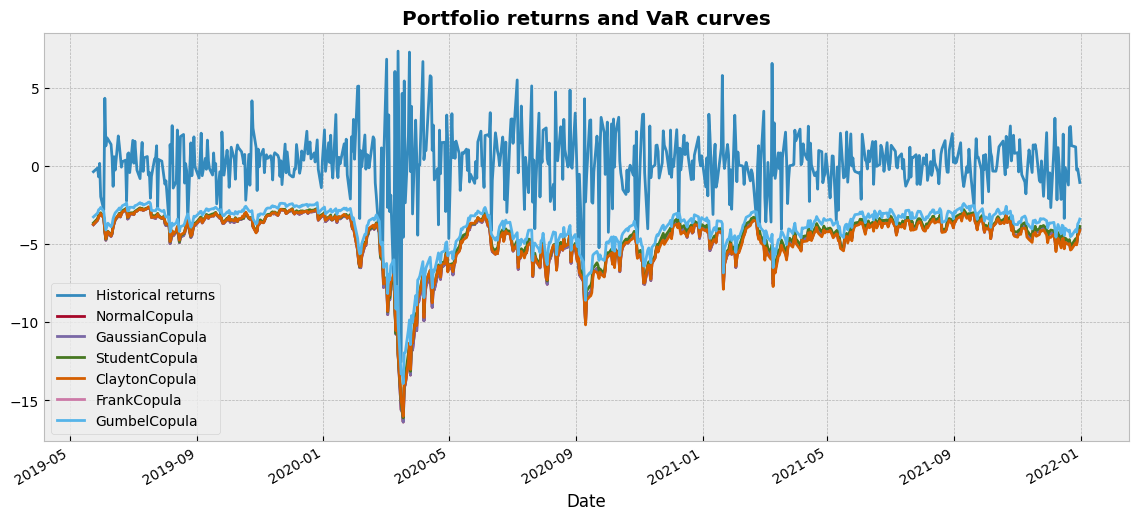

In [15]:
fig = plt.figure()
fig.set_size_inches(14,6)
portfolio.plot(label='Historical returns')
for i in range(len(results_different_copula)):
    results_different_copula[i].plot(label=copula_names[i])

plt.title("Portfolio returns and VaR curves", weight="bold")
plt.legend()
plt.show()

##### тесты Купика

In [16]:
for i in range(len(results_different_copula)):
    print(f'Используя копулу \033[1m{copula_names[i]}\033[0m:')
    kupiec_test(results_different_copula[i], portfolio)
    print('*'*100)

Используя копулу NormalCopula:
Количество наблюдений: 658
Желаемый уровень пробитий: 5.0%
Уровень пробитий в модели: 0.91%

p-value теста: 0.000

При уровне значимости 5.0% гипотеза гипотеза о том, что эмпирическая 
        и модельная частоты превышений фактическими убытками границы VaR равны, 
        отвергается
****************************************************************************************************
Используя копулу GaussianCopula:
Количество наблюдений: 658
Желаемый уровень пробитий: 5.0%
Уровень пробитий в модели: 0.91%

p-value теста: 0.000

При уровне значимости 5.0% гипотеза гипотеза о том, что эмпирическая 
        и модельная частоты превышений фактическими убытками границы VaR равны, 
        отвергается
****************************************************************************************************
Используя копулу StudentCopula:
Количество наблюдений: 658
Желаемый уровень пробитий: 5.0%
Уровень пробитий в модели: 1.52%

p-value теста: 0.000

При уровне знач

##### Во всех случаях уровень пробитий в модели статистически отличается от желаемого уровня пробитий, однако если сравнивать результаты друг с другом, то получаем, что при использовании GumbelCopula результат наиболее близок к желаемому (чуть больше 2%). Поэтому далее буду именно для этой модели подбирать количество лагов. Процесс обучения занимает очень большой промежуток времени, поэтому буду перебирать лаги по очереди.

### Подбор p

In [17]:
%%time
%%capture

with mp.Pool(mp.cpu_count()) as pool:
    results_different_lags_p = pool.starmap(get_var_curve_copula, 
                                            [(GumbelCopula,5,p,0,1) for p in range(1,6)])
    

CPU times: user 113 ms, sys: 72.5 ms, total: 185 ms
Wall time: 31min 45s


##### Визуализация

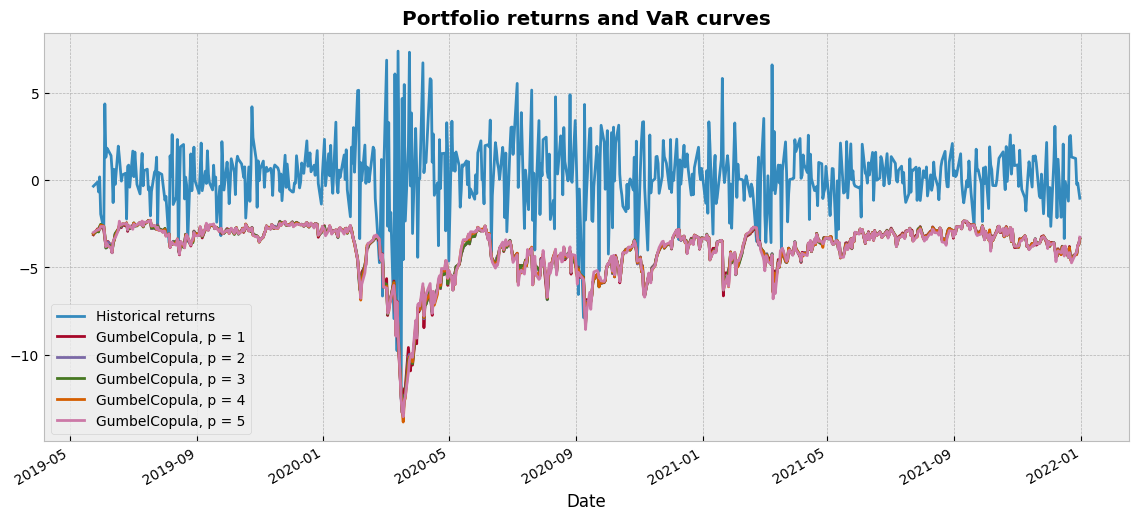

In [18]:
fig = plt.figure()
fig.set_size_inches(14,6)
portfolio.plot(label='Historical returns')
for p in range(5):
    results_different_lags_p[p].plot(label=f'GumbelCopula, p = {p+1}')

plt.title("Portfolio returns and VaR curves", weight="bold")
plt.legend()
plt.show()

##### тесты Купика

In [19]:
for p in range(len(results_different_lags_p)):
    print(f'\033[1m При p = {p+1}\033[0m:')
    kupiec_test(results_different_lags_p[p], portfolio)
    print('*'*100)

 При p = 1:
Количество наблюдений: 658
Желаемый уровень пробитий: 5.0%
Уровень пробитий в модели: 2.58%

p-value теста: 0.002

При уровне значимости 5.0% гипотеза гипотеза о том, что эмпирическая 
        и модельная частоты превышений фактическими убытками границы VaR равны, 
        отвергается
****************************************************************************************************
 При p = 2:
Количество наблюдений: 658
Желаемый уровень пробитий: 5.0%
Уровень пробитий в модели: 2.74%

p-value теста: 0.004

При уровне значимости 5.0% гипотеза гипотеза о том, что эмпирическая 
        и модельная частоты превышений фактическими убытками границы VaR равны, 
        отвергается
****************************************************************************************************
 При p = 3:
Количество наблюдений: 658
Желаемый уровень пробитий: 5.0%
Уровень пробитий в модели: 2.74%

p-value теста: 0.004

При уровне значимости 5.0% гипотеза гипотеза о том, что эмпирическая 
     

##### В исследуемом диапазоне значений параметра p с ростом p улучшается качество модели (за исключением случая p=4). Зафиксирую p = 5

### Подбор q

In [20]:
%%time
%%capture

with mp.Pool(mp.cpu_count()) as pool:
    results_different_lags_q = pool.starmap(get_var_curve_copula, 
                                            [(GumbelCopula,5,5,0,q) for q in range(1,6)])

CPU times: user 145 ms, sys: 78.6 ms, total: 223 ms
Wall time: 45min 58s


##### Визуализация

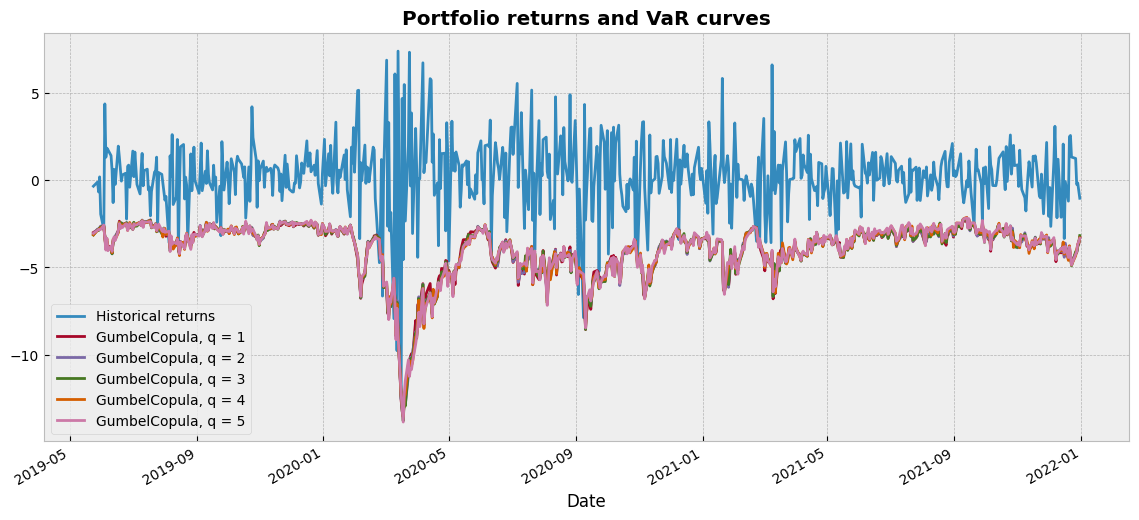

In [21]:
fig = plt.figure()
fig.set_size_inches(14,6)
portfolio.plot(label='Historical returns')
for q in range(5):
    results_different_lags_q[q].plot(label=f'GumbelCopula, q = {q+1}')

plt.title("Portfolio returns and VaR curves", weight="bold")
plt.legend()
plt.show()

##### тесты Купика

In [22]:
for q in range(5):
    print(f'\033[1m При q = {q+1}\033[0m:')
    kupiec_test(results_different_lags_q[q], portfolio)
    print('*'*100)

 При q = 1:
Количество наблюдений: 658
Желаемый уровень пробитий: 5.0%
Уровень пробитий в модели: 2.89%

p-value теста: 0.007

При уровне значимости 5.0% гипотеза гипотеза о том, что эмпирическая 
        и модельная частоты превышений фактическими убытками границы VaR равны, 
        отвергается
****************************************************************************************************
 При q = 2:
Количество наблюдений: 658
Желаемый уровень пробитий: 5.0%
Уровень пробитий в модели: 3.04%

p-value теста: 0.013

При уровне значимости 5.0% гипотеза гипотеза о том, что эмпирическая 
        и модельная частоты превышений фактическими убытками границы VaR равны, 
        отвергается
****************************************************************************************************
 При q = 3:
Количество наблюдений: 658
Желаемый уровень пробитий: 5.0%
Уровень пробитий в модели: 2.74%

p-value теста: 0.004

При уровне значимости 5.0% гипотеза гипотеза о том, что эмпирическая 
     

##### Наибольшее значение p-value при q = 2 => берем его.

### Подбор o

In [23]:
%%time
%%capture

with mp.Pool(mp.cpu_count()) as pool:
    results_different_lags_o = pool.starmap(get_var_curve_copula, 
                                            [(GumbelCopula,5,5,o,2) for o in range(1,6)])

CPU times: user 180 ms, sys: 78.9 ms, total: 259 ms
Wall time: 55min 58s


##### Визуализация

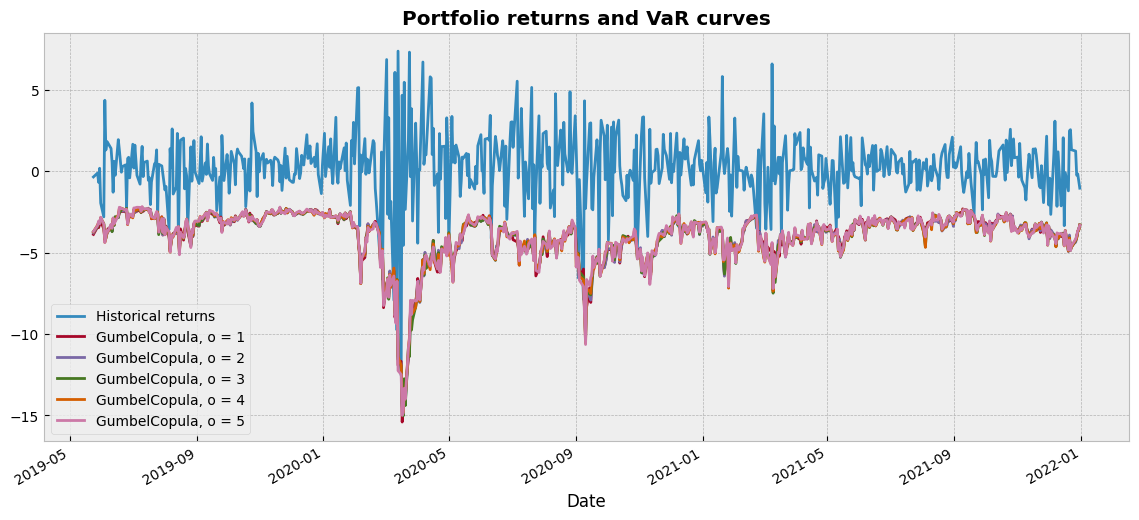

In [24]:
fig = plt.figure()
fig.set_size_inches(14,6)
portfolio.plot(label='Historical returns')
for o in range(5):
    results_different_lags_o[o].plot(label=f'GumbelCopula, o = {o+1}')

plt.title("Portfolio returns and VaR curves", weight="bold")
plt.legend()
plt.show()

##### тесты Купика

In [25]:
for o in range(5):
    print(f'\033[1m При o = {o+1}\033[0m:')
    kupiec_test(results_different_lags_o[o], portfolio)
    print('*'*100)

 При o = 1:
Количество наблюдений: 658
Желаемый уровень пробитий: 5.0%
Уровень пробитий в модели: 2.13%

p-value теста: 0.000

При уровне значимости 5.0% гипотеза гипотеза о том, что эмпирическая 
        и модельная частоты превышений фактическими убытками границы VaR равны, 
        отвергается
****************************************************************************************************
 При o = 2:
Количество наблюдений: 658
Желаемый уровень пробитий: 5.0%
Уровень пробитий в модели: 2.43%

p-value теста: 0.001

При уровне значимости 5.0% гипотеза гипотеза о том, что эмпирическая 
        и модельная частоты превышений фактическими убытками границы VaR равны, 
        отвергается
****************************************************************************************************
 При o = 3:
Количество наблюдений: 658
Желаемый уровень пробитий: 5.0%
Уровень пробитий в модели: 2.58%

p-value теста: 0.002

При уровне значимости 5.0% гипотеза гипотеза о том, что эмпирическая 
     

##### Максимальное значение p-value при o=4, однако оно меньше, чем в случае, когда o=0 (когда подбирался q, o было равно 0). Поэтому возьму o=0.

### Таким образом, выбираю модель с GumbelCopula и p=5, o=0, q=2

### Подбор весов портфеля

In [48]:
from scipy.optimize import minimize

# объявляем целевую функцию, которую мы будем минимизировать 
def calculate_objective_function(weights, returns_simulation, alpha, objective_type):
    portfolio_simulation = np.dot(returns_simulation.values, weights)
    if objective_type == 'return':
        return -np.mean(portfolio_simulation)
    elif objective_type == 'var':
        return -np.quantile(portfolio_simulation, alpha)
    elif objective_type == 'E_Success/E_shortfall':
        VaR = np.quantile(portfolio_simulation, alpha)
        top_var = np.quantile(portfolio_simulation, 1 - alpha)
        E_shortfall = portfolio_simulation[portfolio_simulation < VaR].mean()
        E_success = portfolio_simulation[portfolio_simulation > top_var].mean()
        '''
        E_success/E_shortfall уже меньше нуля (т.к. E_shortfall в таком обозначении 
        меньше нуля) => для максимизации отношения Expected Success/Shortfall Ratio
        нужно минимизировать E_success/E_shortfall без минуса'''
    return E_success/E_shortfall  
    
    
def optimize(returns_simulation, alpha=0.1, objective_type='var'):
    init_guess = np.ones(shape=(returns.shape[1],)) / returns.shape[1]
    bounds = ((-1.0, 1.0),) * returns.shape[1]
    weights = minimize(calculate_objective_function, init_guess,
                       args=(returns_simulation, alpha, objective_type), method='SLSQP',
                       options={'disp': False},
                       constraints=({'type': 'eq', 'fun': lambda inputs: 1.0 - np.sum(inputs)}),
                       bounds=bounds)
    return weights.x

##### Сравним поведение четырех портфелей - с константными весами, и с весами, которые максимизируют Expected Success/Shortfall Ratio, минимизируют VaR и максимизируют Expected return

In [49]:
%%time
%%capture

alpha = 0.1

w = np.ones(shape=(returns.shape[1],)) / 5

T = len(ret)
T_start = 100
estimation_window = 250
testing_window = T - estimation_window

value = 100

value_const_weights = [value]
value_opt_weights_return = [value]
value_opt_weights_var = [value]
value_opt_weights_es_to_es = [value]


for t in range(estimation_window+T_start, T):
    
    real_returns = returns.iloc[t].values / 100
    
    value_new = np.dot(1+real_returns, w) * value_const_weights[-1]
    value_const_weights.append(value_new)
    
    # фиксируем тренировочное окно и делаем сэмплы
    current_estimation_sample = returns[t-estimation_window:t]
    copula_garch_simulation = make_copula_simulation(current_estimation_sample, 
                                                     GumbelCopula, n_samples=10**4, 
                                                     lags=5, q=5, o=0, p=2, univariate_dist='garch')
    
    # и различными способами оптимизируем веса в портфеле
    w_opt = optimize(copula_garch_simulation, objective_type='return')
    value_new = np.dot(1+real_returns, w_opt) * value_opt_weights_return[-1]
    value_opt_weights_return.append(value_new)
    
    w_opt = optimize(copula_garch_simulation, objective_type='E_Success/E_shortfall')
    value_new = np.dot(1+real_returns, w_opt) * value_opt_weights_es_to_es[-1]
    value_opt_weights_es_to_es.append(value_new)
    
    w_opt = optimize(copula_garch_simulation, objective_type='var')
    value_new = np.dot(1+real_returns, w_opt) * value_opt_weights_var[-1]
    value_opt_weights_var.append(value_new)
    
    
value_const_weights.pop(0)
value_opt_weights_return.pop(0)
value_opt_weights_es_to_es.pop(0)
value_opt_weights_var.pop(0)

value_const_weights = pd.Series(value_const_weights, index=ret[estimation_window+T_start:].index)
value_opt_weights_return = pd.Series(value_opt_weights_return, index=ret[estimation_window+T_start:].index)
value_opt_weights_es_to_es = pd.Series(value_opt_weights_es_to_es, index=ret[estimation_window+T_start:].index)
value_opt_weights_var = pd.Series(value_opt_weights_var, index=ret[estimation_window+T_start:].index)


CPU times: user 33min 5s, sys: 11min 59s, total: 45min 5s
Wall time: 24min 55s


### Построим график изменения стоимости портфеля

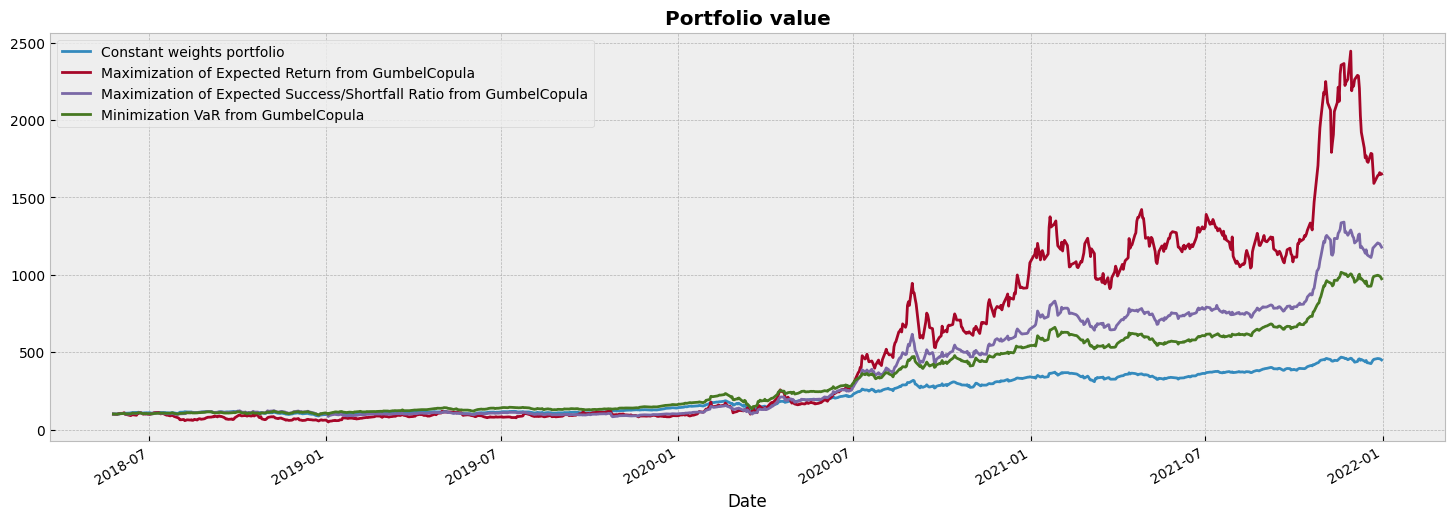

In [50]:
fig = plt.figure()
fig.set_size_inches(18,6)
value_const_weights.plot()
value_opt_weights_return.plot()
value_opt_weights_es_to_es.plot()
value_opt_weights_var.plot()

plt.title("Portfolio value", weight="bold")

plt.legend(['Constant weights portfolio',
            'Maximization of Expected Return from GumbelCopula',
            'Maximization of Expected Success/Shortfall Ratio from GumbelCopula',
            'Minimization VaR from GumbelCopula'
           ])
plt.show()

### Вывод:

Если сравнивать поведение четырех портфелей - с константными весами, и с весами, которые:

а) максимизируют Expected Success/Shortfall Ratio, 

б) минимизируют VaR, 

в) максимизируют Expected return, 

то до января 2020 года значения примерно одинаковые, однако далее становится очевидным то, что портфель с константными весами (по 20%) начинает значительно проигрывать остальным. Способ максимизации отношения 
Expected Success/Shortfall Ratio оказался немного успешнее, чем минимизации VaR портфеля, но несколько "хуже", чем метод максимизации Expected Return (который, естественно, более рискованный, т.к. он рассчитывает лишь матожидание доходности портфеля и не учитывает никакие метрики возможных потерь)

